In [2]:
import os, shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.3.2
 GPU: /device:GPU:0


In [3]:
#the vars and paths that need to change:

label_pred_num = 5

number_to_select = 100

#model path
model_path = './models/VGG16_model_4_8020split_512px'


In [46]:
#the vars and paths that need to change:

########

# #FLORENCE
# #raw images:
# aerial_folder = '../data/pics/raw/Florence_20180917a_jpgs/'
# #import prediction csv
# preds_df = pd.read_csv('../data/tables/FlorenceFourthWithWashLabels20180917a.csv')
# #new csv to save
# newpredcsv = '../data/tables/FlorenceFifthLabels20180917a.csv'
# #AL images path
# ALPATH = '../data/pics/modeltoLabeler/roundFive/Florence5/'

#########

# #MICHAEL
# #raw images:
# aerial_folder = '../data/pics/raw/Michael_20181011a_jpgs/'
# #import prediction csv
# preds_df = pd.read_csv('../data/tables/MichaelFourthWithWashLabels20181011a.csv')
# #new csv to save
# newpredcsv = '../data/tables/MichaelFifthLabels20181011a.csv'
# #AL images path
# ALPATH = '../data/pics/modeltoLabeler/roundFive/Michael5/'

########
#ISAIAS
#raw images:
aerial_folder = '../data/pics/raw/Isaias_20200804a_jpgs/'
#import prediction csv
preds_df = pd.read_csv('../data/tables/IsaiasFourthWithWashLabels20200804a.csv')
#new csv to save
newpredcsv = '../data/tables/IsaiasFifthLabels20200804a.csv'
#AL images path
ALPATH = '../data/pics/modeltoLabeler/roundFive/Isaias5/'

In [33]:
# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)

In [34]:
#load images from Directory
aerials = []
labels = []
for img in os.listdir(aerial_folder):
    #pull the name of the image
    labels.append(img)
    #pull the image
    img = os.path.join(aerial_folder, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(512,512))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    aerials.append(img)
    

In [35]:
#run through model for prediction
aerials = np.vstack(aerials)
wpreds = model.predict(aerials)
#print(wpreds)

(array([399., 246., 191., 309., 492., 284., 236., 230., 251., 844.]),
 array([1.5402300e-20, 9.9999964e-02, 1.9999993e-01, 2.9999989e-01,
        3.9999986e-01, 4.9999982e-01, 5.9999979e-01, 6.9999975e-01,
        7.9999971e-01, 8.9999968e-01, 9.9999964e-01], dtype=float32),
 <a list of 10 Patch objects>)

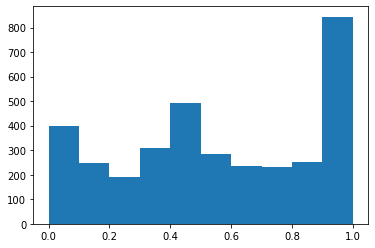

In [36]:
#just an idiot check
#np.histogram(wpreds)
fig,ax = plt.subplots(1,1)
ax.hist(wpreds, bins=10)

In [37]:
aerial_labels = np.vstack(np.asarray(labels))
#print(aerial_labels)

In [38]:
#make them a dataframe
newpred_df = pd.DataFrame(data=np.hstack((aerial_labels,wpreds)), columns=["image", "prediction4"])
#newpred_df

In [39]:
#append/join to catalog df and prediction via the 'image' column in hurricane.csv save as csv
preds = preds_df.join(newpred_df.set_index('image'), on='image')

#add two columns: washover, labeled
#preds["washover"] = ""
#preds["labeled"] = np.nan

preds.head()

,Unnamed: 0,file,storm_id,archive,image,size,date,lr_lon,ul_lat,ll_lat,...,prediction2,washover,labeled,pred_certainty,pred_certainty2,washImages,prediction3,pred_certainty3,washImages3,prediction4
0,0,20200804a_jpgs/jpgs/S21776978.jpg,isaias,20200804a_jpgs,S21776978.jpg,6705271,2020/08/04,-79.889175,32.857442,32.854921,...,0.108500,NaN,NaN,0.493533,0.391500,0.641500,0.282298,0.217702,0.667702,0.29071233
1,1,20200804a_jpgs/jpgs/S21766393.jpg,isaias,20200804a_jpgs,S21766393.jpg,6259383,2020/08/04,-75.959077,35.095388,35.086077,...,0.969360,NaN,NaN,0.253434,0.469360,0.219360,0.999192,0.499192,0.049192,0.92110944
2,2,20200804a_jpgs/jpgs/S21767012.jpg,isaias,20200804a_jpgs,S21767012.jpg,6009380,2020/08/04,-76.294318,34.863638,34.853882,...,0.947221,NaN,NaN,0.286389,0.447221,0.197221,0.999670,0.499670,0.049670,0.86868393
3,3,20200804a_jpgs/jpgs/S21775298.jpg,isaias,20200804a_jpgs,S21775298.jpg,5281908,2020/08/04,-79.351721,33.014702,33.004522,...,0.437554,NaN,NaN,0.141310,0.062446,0.312446,0.999799,0.499799,0.049799,0.96179104
4,4,20200804a_jpgs/jpgs/S21770086.jpg,isaias,20200804a_jpgs,S21770086.jpg,7279868,2020/08/04,-77.485597,34.457228,34.446724,...,0.940632,NaN,NaN,0.201684,0.440632,0.190632,0.999940,0.499940,0.049940,0.9391959


In [40]:
#make new column certainty of prediction, from 0 to 0.5... 0 is smallest certainty
preds["pred_certainty4"] = abs(preds["prediction4"].astype(float) - 0.5)

#select top X each that have not been labeled
uncertain_preds = preds[preds.labeled.isna()].nsmallest(number_to_select, 'pred_certainty4')

uncertain_preds.head()

maxval = max(uncertain_preds['pred_certainty4'])

#add label number for all the images that will be labeled
preds.loc[(preds['pred_certainty4'] <= maxval) & (preds['labeled'].isna()), 'labeled'] = label_pred_num

preds.head()
#save the data
preds.to_csv(newpredcsv, index=False)

In [41]:
preds.head()

,Unnamed: 0,file,storm_id,archive,image,size,date,lr_lon,ul_lat,ll_lat,...,washover,labeled,pred_certainty,pred_certainty2,washImages,prediction3,pred_certainty3,washImages3,prediction4,pred_certainty4
0,0,20200804a_jpgs/jpgs/S21776978.jpg,isaias,20200804a_jpgs,S21776978.jpg,6705271,2020/08/04,-79.889175,32.857442,32.854921,...,NaN,NaN,0.493533,0.391500,0.641500,0.282298,0.217702,0.667702,0.29071233,0.209288
1,1,20200804a_jpgs/jpgs/S21766393.jpg,isaias,20200804a_jpgs,S21766393.jpg,6259383,2020/08/04,-75.959077,35.095388,35.086077,...,NaN,NaN,0.253434,0.469360,0.219360,0.999192,0.499192,0.049192,0.92110944,0.421109
2,2,20200804a_jpgs/jpgs/S21767012.jpg,isaias,20200804a_jpgs,S21767012.jpg,6009380,2020/08/04,-76.294318,34.863638,34.853882,...,NaN,NaN,0.286389,0.447221,0.197221,0.999670,0.499670,0.049670,0.86868393,0.368684
3,3,20200804a_jpgs/jpgs/S21775298.jpg,isaias,20200804a_jpgs,S21775298.jpg,5281908,2020/08/04,-79.351721,33.014702,33.004522,...,NaN,NaN,0.141310,0.062446,0.312446,0.999799,0.499799,0.049799,0.96179104,0.461791
4,4,20200804a_jpgs/jpgs/S21770086.jpg,isaias,20200804a_jpgs,S21770086.jpg,7279868,2020/08/04,-77.485597,34.457228,34.446724,...,NaN,NaN,0.201684,0.440632,0.190632,0.999940,0.499940,0.049940,0.9391959,0.439196


In [42]:
preds["prediction4"] = pd.to_numeric(preds["prediction4"])

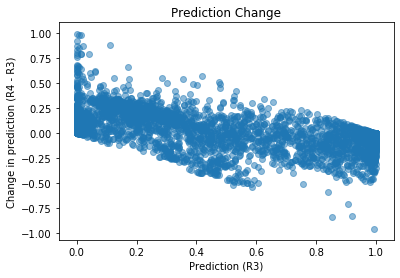

In [43]:
x = preds.prediction3
y = (preds.prediction4 - preds.prediction3)
plt.scatter(x, y, alpha=0.5)

plt.xlabel('Prediction (R3)')
plt.ylabel('Change in prediction (R4 - R3)')

plt.title("Prediction Change")

plt.show()

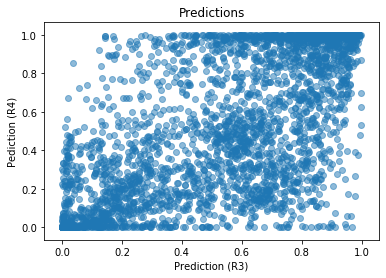

In [44]:
x = preds.prediction2
y = preds.prediction3
plt.scatter(x, y, alpha=0.5)

plt.xlabel('Prediction (R3)')
plt.ylabel('Pediction (R4)')

plt.title("Predictions")

plt.show()

In [47]:
#add the path
uncertain_preds['Image_Path'] = aerial_folder + uncertain_preds['image'].astype(str)

#pull out the list from the df
Labeled_list= uncertain_preds['Image_Path'].tolist()

#move those on the list
for f in Labeled_list:
    shutil.copy(f, ALPATH)